<a href="https://colab.research.google.com/github/ranieri-unimi/git.ammagamma/blob/main/SOLUTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!cd /content
%cd /content

In [ ]:
!pip install spacy-nightly --pre

In [ ]:
!pip install -U pip setuptools wheel

In [ ]:
!pip install -U spacy transformers

In [ ]:
!git clone https://github.com/explosion/projects.git spacy-projects

In [ ]:
!cp -r /content/spacy-projects/tutorials/textcat_goemotions/* /content

In [ ]:
!spacy project assets

In [ ]:
!spacy project run preprocess

In [ ]:
!spacy project run train

In [ ]:
!spacy project run evaluate

In [ ]:
import spacy
nlp = spacy.load("./training/cnn/model-best")

# texts = [
#     "It was really bad to watch you leave, hopefully you'll be back soon",
#     "Oh yes, I can relate to that. Still, you'd better think about it twice.",
# ]

# for doc in nlp.pipe(texts):
#     # Do something with the doc here
#     print(doc.cats)

In [ ]:
import requests
from bs4 import BeautifulSoup

offset = 0
max_offset = 1649
offset_increment = 12

BASE_URL = 'http://www.forexrate.co.uk/'

In [ ]:
news_archive = []

for i in range(0,max_offset,offset_increment):
  url = f'http://www.forexrate.co.uk/newsarchive.php?q=EURUSD&start={i}'
  print(url)
  page = requests.get(url)
  soup = BeautifulSoup(page.content, 'html.parser')
  tables = soup.findChildren('table')
  news_table = tables[1]
  rows = news_table.findChildren(['th', 'tr'])

  for idx,row in enumerate(rows):
    if idx == 0:
        continue
    cells = row.findChildren('td')
    for idx,cell in enumerate(cells):
      txt = cell.text
      href = cell.find('a')['href']
      href = BASE_URL + href.replace('./','')
      if "newsarchive.php?start=" in href:
        continue
      # let's get the date of the article
      date_page = requests.get(href)
      date_soup = BeautifulSoup(date_page.content, 'html.parser')
      date_div = date_soup.findChildren('div')[3]
      date_str = date_div.text
      news_archive.append({'txt':txt,'url':href,'date':date_str})
      # print(len(news_archive), date_str, {'txt':txt,'url':href,'date':date_str})
      #print(value, href)
  #print(len(news_archive))

#print(news_archive)

In [ ]:
import pandas as pd
from datetime import date

In [ ]:
df = pd.DataFrame(news_archive)
df.date = pd.to_datetime(df.date)
df.date = df.date.apply(lambda x : x.date())
df = df.drop(columns='url')
df

In [ ]:
sa = pd.DataFrame([doc.cats for doc in nlp.pipe(df.txt)])

In [ ]:
ds = pd.concat([df, sa], axis=1)
ds = ds.groupby('date').mean()

In [ ]:
ds = ds.set_index('date')

In [ ]:
# *IMPORT LIBRARIES USED*

!pip install fbprophet
!pip install yfinance

from fbprophet import Prophet
from datetime import date
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
from plotly import graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time

In [ ]:
start = ds.date.min()
end = date.today()
#custom_end = pd.to_datetime('2022-05-22')
#end = custom_end

In [ ]:
# In yfinance
tickers_to_download = ['EURUSD=X', 'GBPUSD=X', 'USDCHF=X', 'USDJPY=X', 'EURJPY=X', 'USDCAD=X', 'AUDUSD=X']

In [ ]:
forex_df_list = []

for ticker in tickers_to_download:
  ts = yf.download(ticker, start, end)['Close']
  ts = ts.rename(ticker.lower().split('=', 1)[0] + '_close')
  forex_df_list.append(ts)

forex_df = pd.concat(forex_df_list, axis=1)

In [ ]:
forex_df = forex_df.reset_index().rename(columns={'Date':'date'}).set_index('date')

In [ ]:
forex_df = pd.merge(forex_df, ds, left_index=True, right_index=True)

In [ ]:
del forex_df['txt']

In [ ]:
forex_df.tail()

In [ ]:
# define test and train window
train_window =  ['2010-01-03','2020-10-31']
test_window =  ['2020-11-01','2021-06-10']

In [ ]:
forex_df = forex_df.reset_index().rename(columns={'eurusd_close':'y', 'date':'ds'})

In [ ]:
# forex_df.reset_index().info()

In [ ]:
# # create train and test dataset
# train = forex_df[train_window[0]:train_window[1]]
# test = forex_df[test_window[0]:test_window[1]]

In [157]:
train, test = np.split(forex_df, [int(.85*len(df))])

In [158]:
regressors = list(forex_df.columns[2:])

In [159]:
forex_df.head()

,ds,y,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close,admiration,amusement,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,2019-01-07,1.141044,1.273496,0.98576,108.522003,123.820999,1.33693,0.712378,0.013909,0.024614,...,0.015424,0.006933,0.067459,0.002112,0.032476,0.005597,0.022079,0.022016,0.022829,0.537924
1,2019-01-07,1.141044,1.273496,0.98576,108.522003,123.820999,1.33693,0.712378,0.147116,0.014729,...,0.001864,0.004434,0.022855,0.001970,0.014547,0.003824,0.009326,0.011078,0.175425,0.449918
2,2019-01-08,1.147974,1.278609,0.97910,108.615997,124.660004,1.32960,0.714592,0.140054,0.008203,...,0.010851,0.006127,0.116855,0.004616,0.024335,0.006465,0.023158,0.008795,0.029969,0.251205
3,2019-01-08,1.147974,1.278609,0.97910,108.615997,124.660004,1.32960,0.714592,0.013495,0.036074,...,0.009748,0.006055,0.026199,0.003437,0.049715,0.005762,0.020900,0.008569,0.043234,0.373623
4,2019-01-10,1.155495,1.279967,0.97395,108.189003,125.014999,1.32115,0.717566,0.026616,0.023812,...,0.011638,0.002862,0.050510,0.001437,0.013197,0.003104,0.031731,0.012535,0.024738,0.953293


In [166]:
forex_df[['ds', 'y']+['optimism', 'neutral', 'surprise']]

,ds,y,optimism,neutral,surprise
0,2019-01-07,1.141044,0.067459,0.537924,0.022829
1,2019-01-07,1.141044,0.022855,0.449918,0.175425
2,2019-01-08,1.147974,0.116855,0.251205,0.029969
3,2019-01-08,1.147974,0.026199,0.373623,0.043234
4,2019-01-10,1.155495,0.050510,0.953293,0.024738
...,...,...,...,...,...
1411,2022-05-31,1.077354,0.039978,0.807200,0.050262
1412,2022-06-01,1.073411,0.037371,0.318391,0.061833
1413,2022-06-01,1.073411,0.028222,0.968630,0.018864
1414,2022-06-06,1.072605,0.021322,0.455397,0.043727


In [160]:
m = Prophet()
for r in regressors:
  m.add_regressor(r)
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [161]:
future = m.make_future_dataframe(20, freq='B')

In [162]:
future

,ds
0,2019-01-07
1,2019-01-08
2,2019-01-10
3,2019-01-11
4,2019-02-05
...,...
712,2022-06-14
713,2022-06-15
714,2022-06-16
715,2022-06-17


In [ ]:
future = m.make_future_dataframe(20, freq='B') # Explain B
forecast = m.predict(future)

forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)
forecast_results.set_index('ds', inplace=True)

In [164]:
forecast_results

,yhat,yhat_lower,yhat_upper
ds,,,
2022-05-24,1.051035,1.041655,1.059854
2022-05-25,1.050938,1.041495,1.060102
2022-05-26,1.050566,1.042229,1.059582
2022-05-27,1.050172,1.040252,1.059871
2022-05-30,1.049108,1.040475,1.058641
2022-05-31,1.048723,1.039545,1.057769
2022-06-01,1.048395,1.039592,1.058334
2022-06-02,1.047756,1.038899,1.057108
2022-06-03,1.047063,1.038257,1.056536


In [137]:
final_df_results = pd.merge(test.set_index('ds')[['y']], forecast_results[['yhat']], left_index=True, right_index=True, how='inner')

In [138]:
final_df_results

,y,yhat
ds,,
2022-05-24,1.068205,1.051035
2022-05-24,1.068205,1.051035
2022-05-25,1.073653,1.050938
2022-05-25,1.073653,1.050938
2022-05-26,1.068661,1.050566
2022-05-26,1.068661,1.050566
2022-05-27,1.073295,1.050172
2022-05-27,1.073295,1.050172
2022-05-30,1.073146,1.049108


In [139]:
# Errors
def calc_errors(test, preds):
    percentiles = [5, 25, 50, 75, 95]
    elementwise_mae = np.absolute(np.subtract(preds, test))
    # Mean mae https://en.wikipedia.org/wiki/Mean_absolute_error
    mean_mae = sum(elementwise_mae) / len(test)
    print(f"Mean MAE: {mean_mae:.2f}")
    percent_mae = sum(elementwise_mae) / sum(test)
    print(f"MAE%: {percent_mae * 100:.2f}%")
    # Rmse https://en.wikipedia.org/wiki/Root-mean-square_deviation
    rmse = np.sqrt(np.mean(np.power(np.subtract(preds, test), 2)))
    print(f"RMSE: {rmse:.2f}")
    # Bias https://en.wikipedia.org/wiki/Bias_(statistics)
    bias = np.mean(np.subtract(preds, test))
    print(f"Bias: {bias:.2f}\n")
    # Mae distrib
    distr_mae = []
    for perc in percentiles:
        temp_mae = np.percentile(elementwise_mae, perc)
        distr_mae.append(temp_mae)
        print(f"{perc}th percetile MAE: {temp_mae:.2f}")
    # Plot MAE distribution
    plt.figure(figsize=(8, 8))
    plt.title('MAE distribution')
    plt.xlabel('MAE')
    plt.ylabel('Count')
    # Plot distr
    plt.hist(elementwise_mae, bins=30)
    # plot mean MAE
    plt.axvline(x=mean_mae, label='Mean MAE', c='r', linestyle='-')
    # plot percentiles
    line_types = [':', '-.', '--', '-.', ':']
    for xc, lt, p in zip(distr_mae, line_types, percentiles):
        plt.axvline(x=xc, label='{}th percentile MAE'.format(p), c='r', linestyle=lt)
    plt.legend()
    plt.show()


In [145]:
import matplotlib.pyplot as plt

Mean MAE: 0.02
MAE%: 2.17%
RMSE: 0.02
Bias: -0.02

5th percetile MAE: 0.02
25th percetile MAE: 0.02
50th percetile MAE: 0.02
75th percetile MAE: 0.03
95th percetile MAE: 0.03


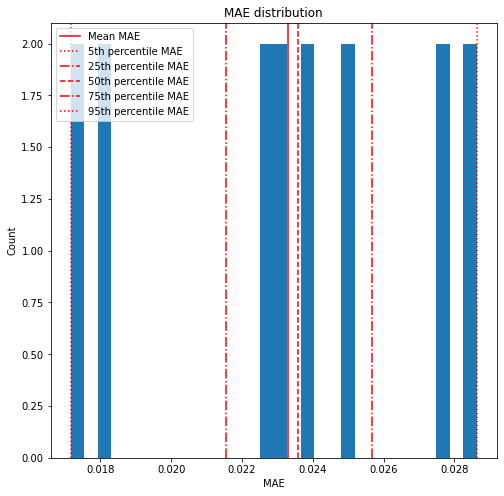

In [146]:
# Analyze the forecast error
calc_errors(final_df_results['y'].values, final_df_results['yhat'].values)


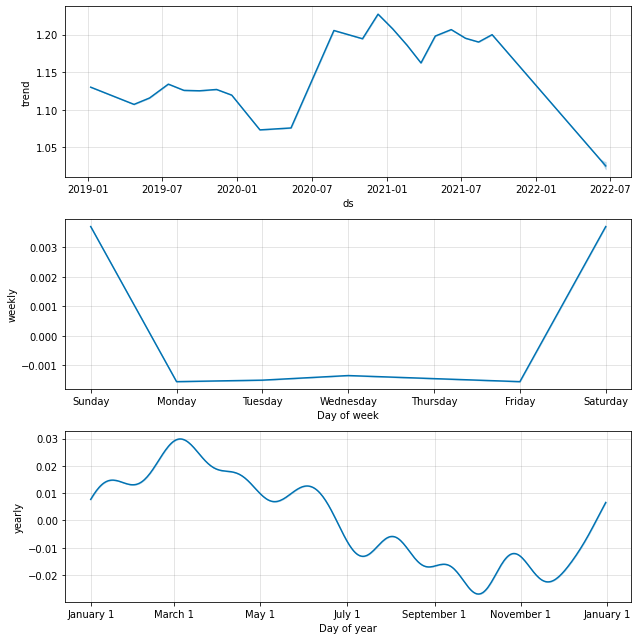

In [147]:
# explore the components of the fitted model
fig = m.plot_components(forecast)

In [149]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['y'],
                    mode='lines+markers',
                    name='Real Values'))

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['yhat'],
                    mode='lines+markers',
                    name='Predicted Values'))

fig.update_layout(template='plotly_white')
fig.show()

In [ ]:
"""
          Locatelli
          Ranieri
          Nakka
"""